
##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [0]:
# Copyright 2019 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP Training

This notebook demonstrates a simple example of training a DDSP autoencoder.

In [0]:
# Imports.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import ddsp
import ddsp.training

from colabtools import sound
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# Helper functions.
sample_rate = 16000
play = lambda x: sound.Play(x, sample_rate)
f32 = ddsp.core.f32

def specplot(audio, vmin=-5, vmax=1, rotate=True, size=512 + 256):
  with tf.Session() as sess:
    logmag = sess.run(ddsp.spectral_ops.calc_logmag(f32(audio), size=size))
  if rotate:
    logmag = np.rot90(logmag)
  plt.matshow(logmag, vmin=vmin, vmax=vmax, cmap=plt.cm.magma, aspect='auto')
  plt.xticks([])
  plt.yticks([])

# Get a Batch of Data

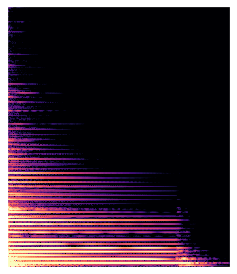

In [10]:
# Get a single example from NSynth.
# Takes a few seconds to load from GCS.
data_provider = ddsp.training.data.NSynthTfds(split='train')
batch = data_provider.get_batch(batch_size=1, shuffle=False)
audio = tfds.as_numpy(batch).next()['audio']
n_samples = audio.shape[1]

specplot(audio[0])
play(audio[0])

# Instantiate the model

## Python

In [0]:
preprocessing = ddsp.training.preprocessing
encoders = ddsp.training.encoders
decoders = ddsp.training.decoders
models = ddsp.training.models
TIME_STEPS = 1000

# Create Neural Networks.
preprocessor = preprocessing.DefaultPreprocessor(time_steps=TIME_STEPS)

encoder = encoders.MfccTimeDistributedRnnEncoder(rnn_channels=512,
                                                 rnn_type='gru',
                                                 z_dims=16,
                                                 z_time_steps=TIME_STEPS)

decoder = decoders.ZRnnFcDecoder(rnn_channels = 512,
                                 rnn_type = 'gru',
                                 ch = 512,
                                 layers_per_stack = 3,
                                 append_f0_loudness = True,
                                 output_splits = (('amps', 1),
                                                  ('harmonic_distribution', 100),
                                                  ('noise_magnitudes', 65)))
    
# Create Processors.
additive = ddsp.synths.Additive(n_samples=n_samples, 
                                sample_rate=sample_rate,
                                name='additive')
noise = ddsp.synths.FilteredNoise(window_size=0, name='noise')
add = ddsp.processors.Add(name='add')

# Create ProcessorGroup.
dag = [(additive, ['amps', 'harmonic_distribution', 'f0_hz']),
       (noise, ['noise_magnitudes']),
       (add, ['noise/signal', 'additive/signal'])]

processor_group = ddsp.processors.ProcessorGroup(dag=dag, name='processor_group')


# Loss_functions
spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)

# Put it together in a model.
model = models.Autoencoder(preprocessor=preprocessor,
                           encoder=encoder,
                           decoder=decoder,
                           processor_group=processor_group,
                           losses=[spectral_loss])

## Or Gin...

In [0]:
gin_string = """
import ddsp
import ddsp.training

# =======
# Network
# =======

# Preprocessor
models.Autoencoder.preprocessor = @preprocessing.DefaultPreprocessor()
preprocessing.DefaultPreprocessor.time_steps = 1000


# Encoder
models.Autoencoder.encoder = @encoders.MfccTimeDistributedRnnEncoder()
encoders.MfccTimeDistributedRnnEncoder.rnn_channels = 512
encoders.MfccTimeDistributedRnnEncoder.rnn_type = 'gru'
encoders.MfccTimeDistributedRnnEncoder.z_dims = 16
encoders.MfccTimeDistributedRnnEncoder.z_time_steps = 125


# Decoder
models.Autoencoder.decoder = @decoders.ZRnnFcDecoder()
decoders.ZRnnFcDecoder.rnn_channels = 512
decoders.ZRnnFcDecoder.rnn_type = 'gru'
decoders.ZRnnFcDecoder.ch = 512
decoders.ZRnnFcDecoder.layers_per_stack = 3
decoders.ZRnnFcDecoder.append_f0_loudness = True
decoders.ZRnnFcDecoder.output_splits = (('amps', 1),
                                        ('harmonic_distribution', 100),
                                        ('noise_magnitudes', 65))


# =================
# Signal Processors
# =================

# ProcessorGroup
models.Autoencoder.processor_group = @processors.ProcessorGroup()

processors.ProcessorGroup.dag = [
  (@additive/synths.Additive(),
    ['amps', 'harmonic_distribution', 'f0_hz']),
  (@noise/synths.FilteredNoise(),
    ['noise_magnitudes']),
  (@add/processors.Add(),
    ['noise/signal', 'additive/signal']),
]

# Additive Synthesizer
additive/synths.Additive.name = 'additive'
additive/synths.Additive.n_samples = 64000
additive/synths.Additive.sample_rate = 16000
additive/synths.Additive.normalize_below_nyquist = True
additive/synths.Additive.amp_scale_fn = @core.exp_sigmoid

# Filtered Noise Synthesizer
noise/synths.FilteredNoise.name = 'noise'
noise/synths.FilteredNoise.n_samples = 64000
noise/synths.FilteredNoise.window_size = 0
noise/synths.FilteredNoise.amp_scale_fn = @core.exp_sigmoid

# Add
add/processors.Add.name = 'add'


# ======
# Losses
# ======

models.Autoencoder.losses = [
    @losses.SpectralLoss(),
]
losses.SpectralLoss.loss_type = 'L1'
losses.SpectralLoss.mag_weight = 1.0
losses.SpectralLoss.logmag_weight = 1.0
"""

with gin.unlock_config():
  gin.parse_config(gin_string)

model = ddsp.training.models.Autoencoder()

# Define Graph

In [0]:
tf.reset_default_graph()
# Single batch.
features_tf = {k:tf.convert_to_tensor(v) for k, v in features_.items()}

# Get model predictions for the batch.
outputs = model(features_tf)
loss = outputs['total_loss']
train_op = ddsp.training.train_util.get_train_op(loss, learning_rate=4e-3)

# Setup the session.
sess = tf.Session('uptc://prod/dragonfish_2x2')
sess.run(tf.initialize_all_variables())

# Train

In [0]:
for i in range(200):
  _, loss_ = sess.run([train_op, loss])
  print('i: {}\tLoss: {}'.format(i, loss_))

# Make Predictions

In [0]:
# Run a batch of predictions. First run is longer because loads model.
start_time = time.time()
predictions_ = sess.run(outputs)
end_time = time.time()
infer_time = end_time - start_time
print('Prediction took %.1f seconds' % infer_time)

# Inspect Outputs

In [0]:
summary = lambda x: print('Max: {:.2g}\t Min: {:.2g}\t Mean: {:.2g}'.format(x.max(), x.min(), x.mean()))
# Initial decoder outputs.
d_out = predictions_['decoder_outputs'][0]
d_out_amp = d_out[:, :1]
d_out_hd = d_out[:, 1:]
summary(d_out_amp)
summary(d_out_hd)

In [0]:
amps = predictions_['additive']['controls']['amplitudes'][0]
summary(amps)

In [0]:
amps = predictions_['additive']['controls']['harmonic_distribution'][0]
summary(amps)

# Analyze results

In [0]:
# Predictions
k = 0

audio = features_['audio'][k]
audio_synth = predictions_['audio_gen'][k]
amps = predictions_['additive']['controls']['amplitudes'][k]
harmonic_distribution = amps = predictions_['additive']['controls']['harmonic_distribution'][k]


f0 = features_['f0'][k]
loudness = features_['loudness'][k]
f0_hz = ddsp.midi_to_hz(f0 * 127.0)

play(audio)
play(audio_synth)

f, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].semilogy(amps)
ax[0].set_xlabel('Amps')
ax[0].set_ylim(1e-5, 2)
ax[1].plot(loudness)
ax[1].set_xlabel('loudness')

specplot(audio)
plt.title('Audio')
specplot(audio_synth)
plt.title('Audio Synth')

plt.matshow(np.rot90(np.log(harmonic_distribution + 1e-5)),
            aspect='auto')
plt.title('Harmonic Distribution')

plt.figure()
plt.plot(harmonic_distribution)
plt.title('Harmonic Distribution')

# plt.figure()
# plt.plot(f0)
# plt.title('F0')

f, ax = plt.subplots(2, 1, figsize=(14, 4))
start_idx = int(0.0 * SR)
length = 1000
end_idx = start_idx + length
ax[0].plot(audio[start_idx:end_idx])
ax[0].set_xlabel('Audio')
ax[1].plot(audio_synth[start_idx:end_idx])
ax[1].set_xlabel('Audio Synth')

plt.figure()
plt.plot(f0_hz)
plt.title('F0_Hz')
